In [2]:
import os 
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, transform    # 图片读取模块
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

plt.ion()   # 交互模式
# %matplotlib inline

In [2]:
# 读取数据
landmarks_frame = pd.read_csv('./datas/faces/face_landmarks.csv')
print('图片数量:%d，标记点数量:%d' % landmarks_frame.shape)

# 提取某一行数据
img_name = landmarks_frame.iloc[0, 0]
landmarks = landmarks_frame.iloc[0, 1:].as_matrix()   # 提取标记点并转化为矩阵
landmarks = landmarks.astype('float').reshape(-1, 2)

print('图片名称：', img_name)
print('标记点形状：', landmarks.shape)
print('标记的部分数据：\n', landmarks[:4, :])

图片数量:69，标记点数量:137
图片名称： 0805personali01.jpg
标记点形状： (68, 2)
标记的部分数据：
 [[ 27.  83.]
 [ 27.  98.]
 [ 29. 113.]
 [ 33. 127.]]


In [3]:
# 获取一个点和
def get_one_image(n, dataframe):
    img_name = dataframe.iloc[n, 0]
    landmarks = dataframe.iloc[n, 1:].as_matrix()   
    landmarks = landmarks.astype('float').reshape(-1, 2)
    return img_name, landmarks


# 查看图片和标记点   
def show_landmarks(image, landmarks):
    plt.imshow(image)    # 展示图片
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r') # 插入点
    plt.pause(0.001)    # 暂停

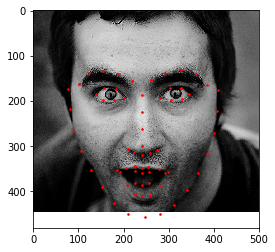

In [4]:
img_name, landmarks = get_one_image(56, landmarks_frame)

show_landmarks(
    io.imread(os.path.join('./datas/faces/', img_name)), landmarks)
# plt.show()

### 自定义一个数据集

In [4]:
# 基于dataset创建一个 face landmarks 的数据类,在初始化时读取csv文件
class FaceLandmarksDataset(Dataset):
    """
    人脸标记数据集
    paramter: csv_file csv文件存放路径
    paramter: root_dir 存放图片的路径
    paramter: transfrom 对样本进行转换
    """
    def __init__(self, csv_file, root_dir, transform=None):
        
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        """查看图片的长度"""
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        """获取指定索引的实例"""
        # 将张量索引转化为数组
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(
            self.root_dir, self.landmarks_frame.iloc[idx, 0])
        
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

(324, 215, 3) (68, 2)


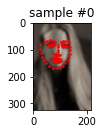

(500, 333, 3) (68, 2)


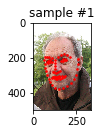

(250, 258, 3) (68, 2)


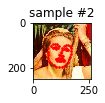

(434, 290, 3) (68, 2)


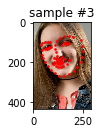

(828, 630, 3) (68, 2)


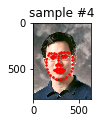

In [6]:
# 实例化数据集对象
face_dataset = FaceLandmarksDataset('./datas/faces/face_landmarks.csv',
                                   './datas/faces')

# 查看指定索引的数据
# face_dataset[1]

# 查看前5张图片
# plt.figure(facecolor='w')
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 5, i+1)
    ax.set_title(f'sample #{i}')
    
    show_landmarks(**sample)
    
    if i == 4:
        break
plt.show()

### 数据集转换
以上实例中的每个样本的大小不一样,在神经网络中要求样本的形状是一样的,以下是样本预处理的代码,首先需要完成如下三个转换
- Rescale: 缩放图片
- RandomCrop: 随机裁剪图片
- ToTensor: 将numpy 类型的图片转为 torch 类型的图片

In [76]:
class Rescale:
    """将图片缩放到给定的尺寸大小
    output_size: 期望输出图片的大小，如果是tuple,则与tuple相同；如果是整型，则输出为
        长宽比相同的
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]     # 取图片的长宽
        
        # 对长宽进行缩放，使长宽之比统一
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))    # 转换图片形状
        
        # 对标记坐标点进行缩放
        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}
    

class RandomCrop:
    """ 随机裁剪样本图片
        output_size: 裁剪的尺寸，如果是整数则裁剪一个正方形   
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top:top + new_h, left:left + new_w]
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}
    

class ToTensor:
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [ ]:
# 使用不同的方法进行标准化
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(250)])

sample = face_dataset[65]
for i, tsf in enumerate([scale, crop, composed]):
    transform_sample = tsf(sample)
    plt.subplot(1, 3, i+1)
    
    show_landmarks(**transform_sample)
    

In [77]:
# 对整个数据集进行转换。并查看
transform_dataset = FaceLandmarksDataset(
    './datas/faces/face_landmarks.csv',
    './datas/faces',
    transform=transforms.Compose([
        Rescale(256),
        RandomCrop(224),
        ToTensor()
    ])
)

for i in range(len(transform_dataset)):
    sample = transform_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())
    if i == 5:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
4 torch.Size([3, 224, 224]) torch.Size([68, 2])
5 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


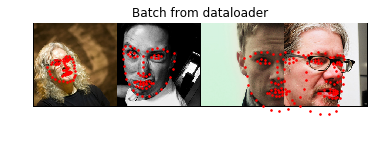

In [85]:
# 将生成的数据集做为Downloadeder对象
dataloader = DataLoader(transform_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# 批量查看数据

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break